# Create Pseudo FGS image out of an `ID_image_cal.fits` image

This notebook will be used during the case that we want to check the 3x3 count rates from the pseudo-FGS image created from the NIRCam image against FGS ID
strips.

In [3]:
import os
from functools import reduce
import logging
import shutil

from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from IPython.display import Image

import fgscountrate
import jwst_magic
from jwst_magic.convert_image import convert_image_to_raw_fgs
from jwst_magic.utils import utils
PACKAGE_PATH = jwst_magic.__file__.split('jwst_magic/__init__.py')[0]

LOGGER = logging.getLogger('convert_merged_id_strips_to_raw-notebook')

%matplotlib inline

Using backend:  Qt5Agg
Your MAGIC package is up to date
**WARNING**: LOCAL FGS COUNTRATE VERSION 2.0.0 IS BEHIND THE CURRENT ONLINE VERSION 3.0.0
Please update FGS COUNTRATE, e.g. run `git pull` and `pip install .`


# Table of Contents
1. [About this Guide Star](#About-this-Guide-Star)
2. [Segment ID matching to MAGIC labeling](#Segment-ID-matching-to-MAGIC-labeling)
2. [Functions](#Functions)
3. [Load in the ID strips merged image](#Load-in-the-ID-strips-merged-image)

# About this observation

Edit the cell below with the guider used for this observations

In [4]:
guider = 1

# Segment ID matching to MAGIC labeling
Run but do not change these cells

In [5]:
if guider==1:
    orientation_filename = "../Commissioning_Support/fgs_raw_orientation_numbering_wss_guider1.png"  
elif guider==2:
    orientation_filename="../Commissioning_Support/fgs_raw_orientation_numbering_wss_guider2.png"
    
magic_grid_filename = "../JWSTgrid_side.png"

In [6]:
print(f'Guider {guider}')

Guider 1


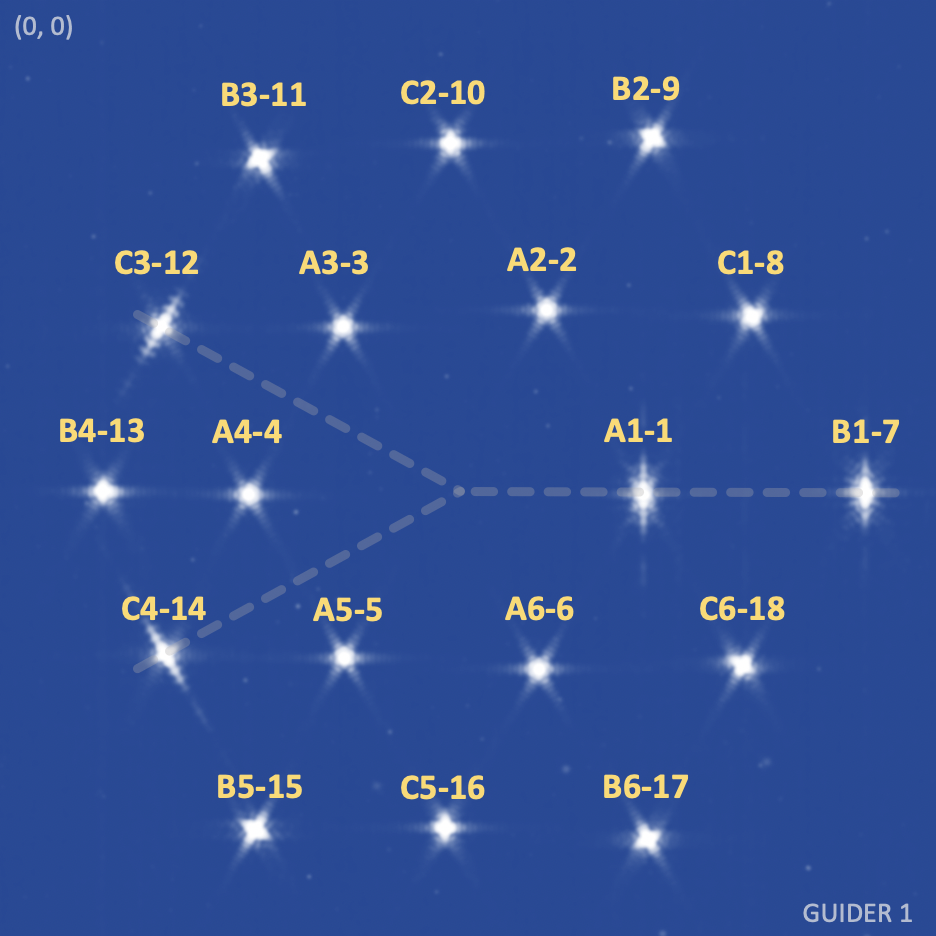

In [7]:
Image(filename=orientation_filename, height=400, width=400)

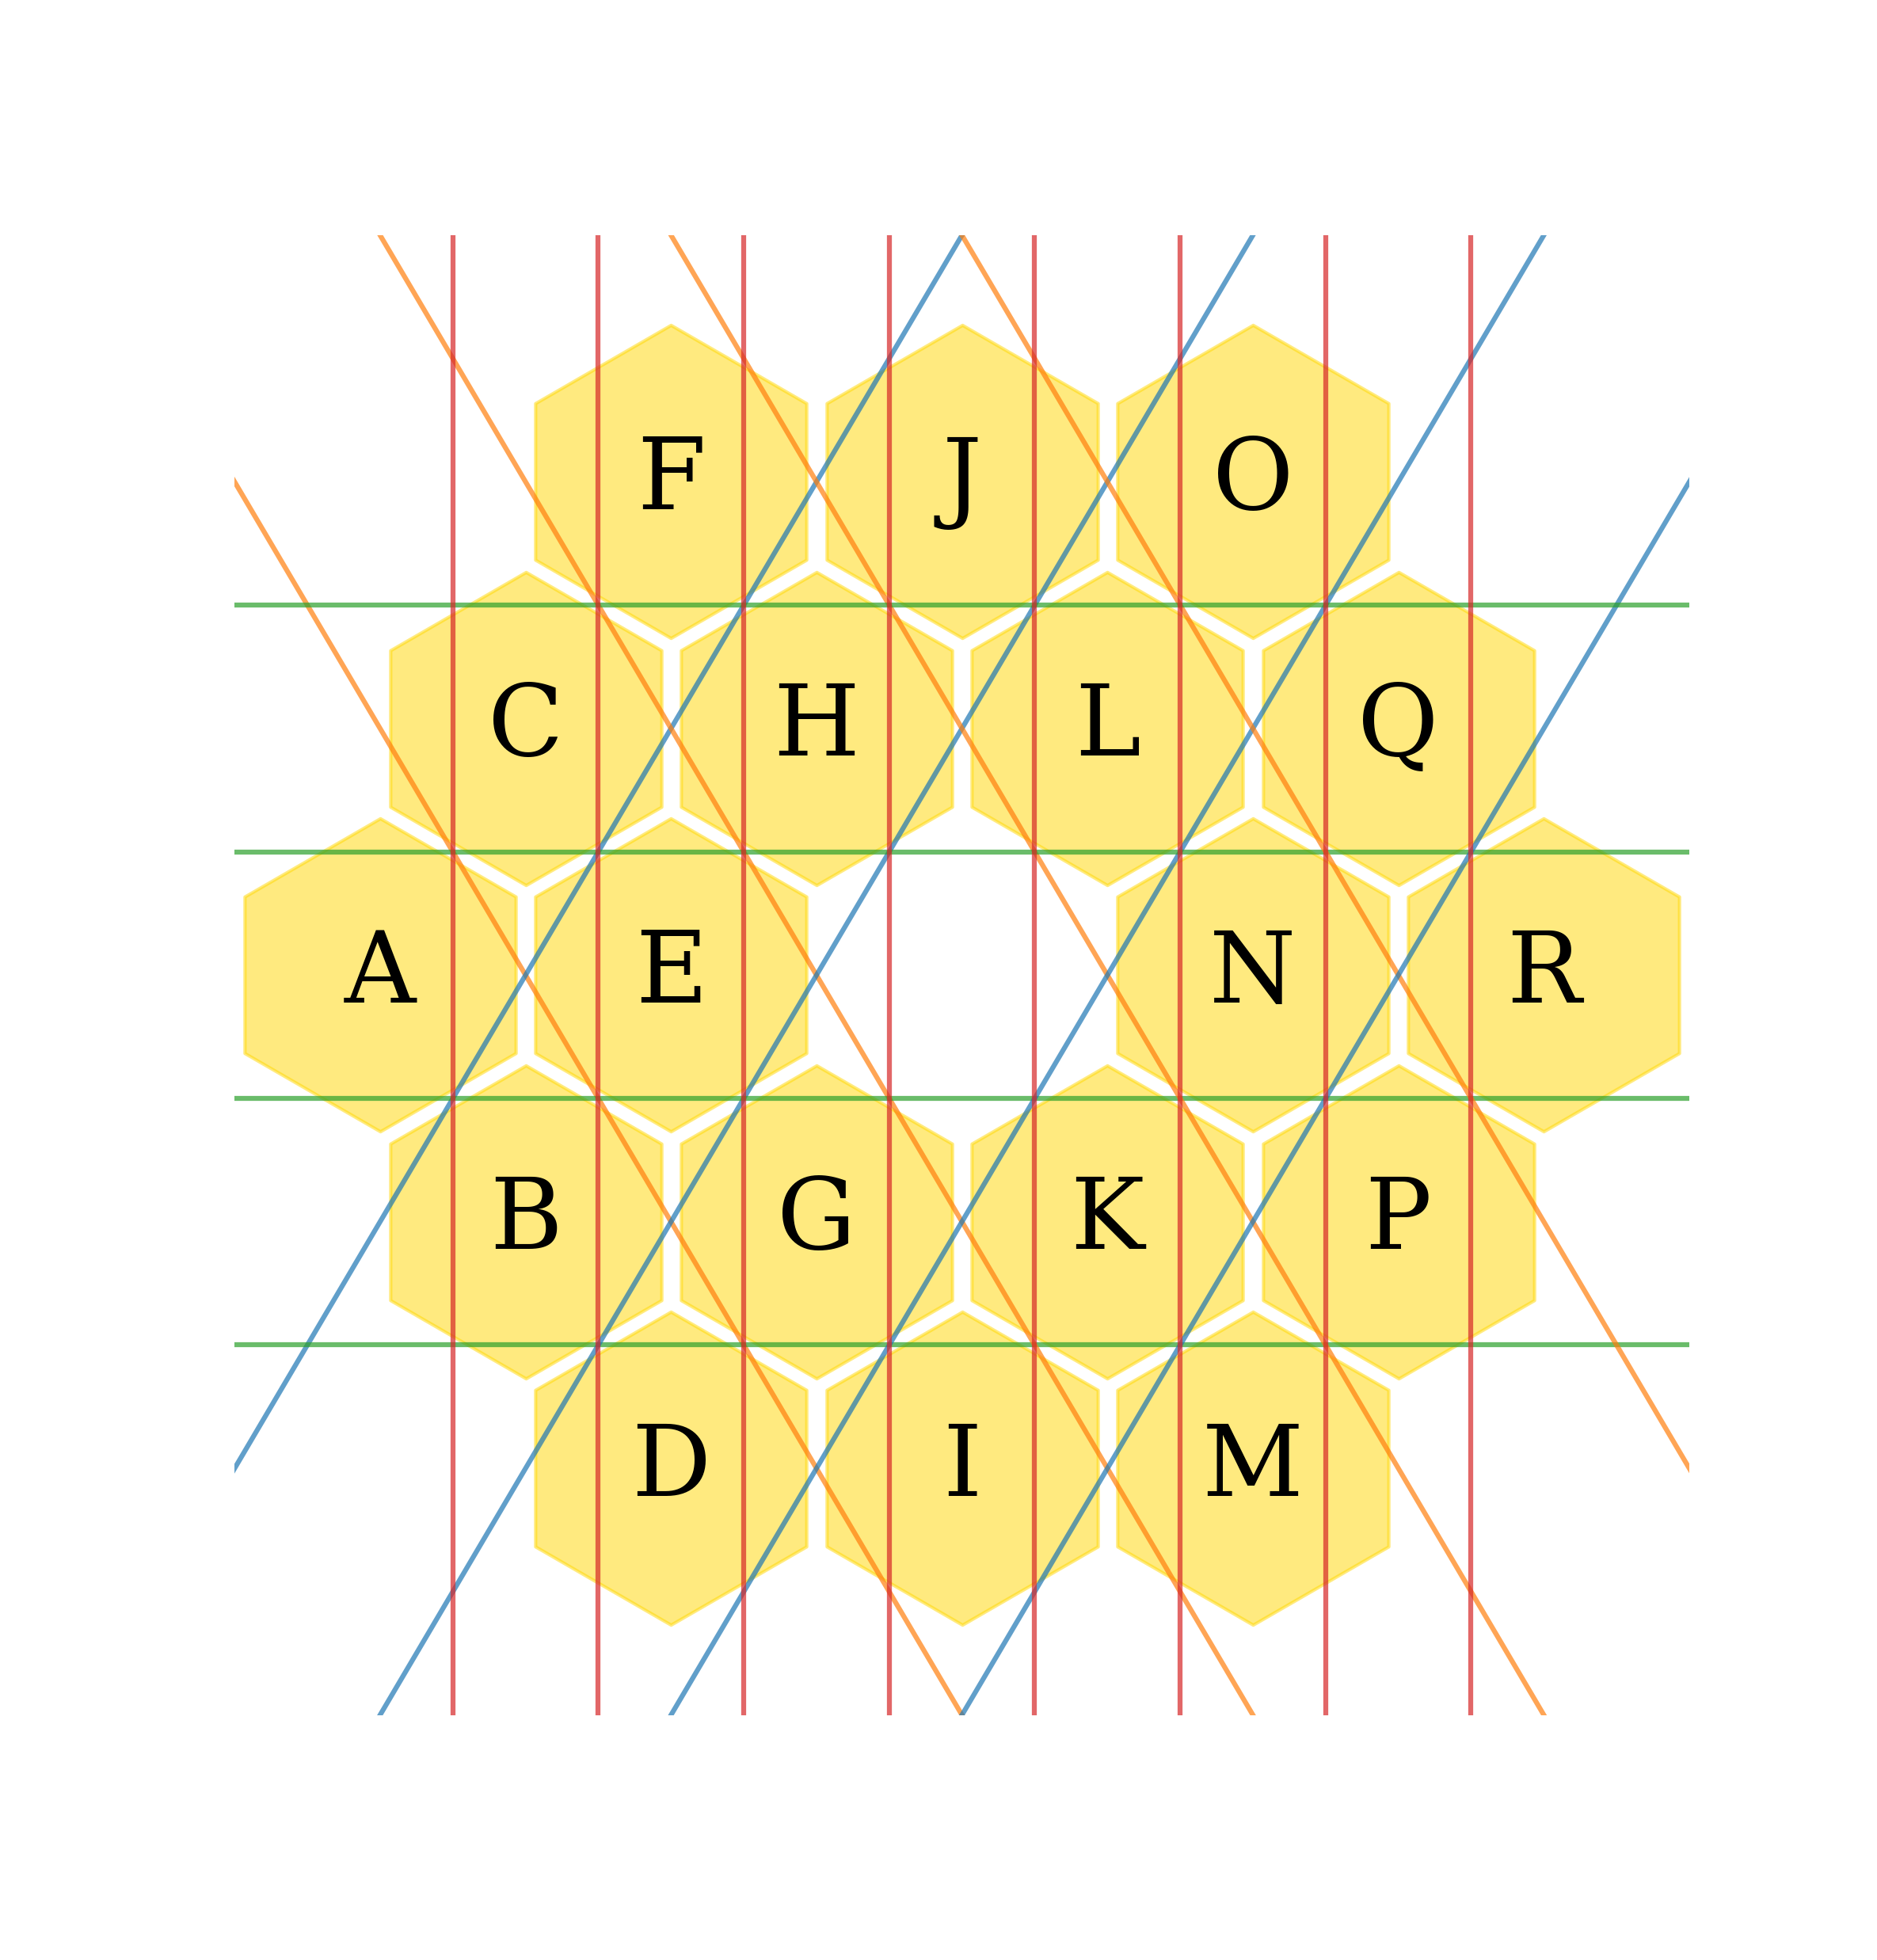

In [8]:
Image(filename=magic_grid_filename, height=400, width=400)

In [9]:
# MAGIC segment labels to segment naming G1 map
SEGMENT_MAP_G1 = {"A":"B4-13", "B":"C4-14", "C":"C3-12", "D":"B5-15",
                  "E":"A4-4", "F":"B3-11", "G":"A5-5", "H":"A3-3", 
                  "I":"C5-16", "J":"C2-10", "K":"A6-6", "L":"A2-2", 
                  "M":"B6-17", "N":"A1-1", "O":"B2-9", "P":"C6-18", 
                  "Q":"C1-8", "R":"B1-7"}

# MAGIC segment lbabels to segment naming G2 map
SEGMENT_MAP_G2 = {"A":"B1-7", "B":"C6-18", "C":"C1-8", "D":"B6-17",
                  "E":"A1-1", "F":"B2-9", "G":"A6-6", "H":"A2-2", 
                  "I":"C5-16", "J":"C2-10", "K":"A5-5", "L":"A3-3", 
                  "M":"B5-15", "N":"A4-4", "O":"B3-11", "P":"C4-14", 
                  "Q":"C3-12", "R":"B4-13"}

# Functions 
Do not change these cells

In [10]:
def read_all_found_psfs(all_psfs_filename):
    """
    Read in the all found PSFs file from MAGIC and map the segment ID to the measured PSF. Return a data frame 
    (table) with the information in this file
    """
    # Read in all found PSFs
    segment_map = SEGMENT_MAP_G1 if guider==1 else SEGMENT_MAP_G2
    
    all_psfs_table = pd.read_csv(all_psfs_filename, comment='#', 
                                 names=['label', 'y', 'x', 'countrate'], sep=' ')
    segments = [segment_map[label] for label in all_psfs_table['label']]

    # Add the segment name to the table
    all_psfs_table.insert(1, 'segment', segments)
    all_psfs_table = all_psfs_table.sort_values('segment', ascending=True)
    
    return all_psfs_table

In [11]:
def convert_id_to_fgs_raw(input_image, root, out_dir, guider, smoothing):
    # Determine filename root
    root = utils.make_root(root, input_image)

    # Determine output directory
    out_dir_root = utils.make_out_dir(out_dir, PACKAGE_PATH, root)
    utils.ensure_dir_exists(out_dir_root)

    # Set up logging
    _, log_filename = utils.create_logger_from_yaml(__name__, out_dir_root=out_dir_root, root=root, level='DEBUG')

    LOGGER.info("Package directory: {}".format(PACKAGE_PATH))
    LOGGER.info("Processing request for {}.".format(root))
    LOGGER.info("All data will be saved in: {}".format(out_dir_root))
    LOGGER.info("Input image: {}".format(os.path.abspath(input_image)))

    # Copy input image into out directory
    try:
        shutil.copy(os.path.abspath(input_image), out_dir_root)
    except shutil.SameFileError:
        pass

    # Convert provided FGS ID image to a "raw" FGS image
    fgs_im, all_found_psfs_file, psf_center_file, fgs_hdr_dict = \
        convert_image_to_raw_fgs.convert_im(input_image, guider, root,
                                            out_dir=out_dir,
                                            nircam=False,
                                            nircam_det=None,
                                            normalize=False,
                                            smoothing=smoothing,
                                            coarse_pointing=False,
                                            jitter_rate_arcsec=None,
                                            logger_passed=True,
                                            itm=False)

    # Add logging information to fgs image header
    fgs_hdr_dict['LOG_FILE'] = (os.path.basename(log_filename), 'Log filename')

    # Write converted image
    convert_image_to_raw_fgs.write_fgs_im(fgs_im, out_dir, root, guider, fgs_hdr_dict)
    LOGGER.info("*** Image Conversion COMPLETE ***")


# Load in the ID strips merged image

We will be loading the `gs-id_<guider>_image_cal.fits` associated with the observation we care about. This a merged ID strips image. It has the shape 2048x2024 so you will need to pad it by 24 rows of zeros. Since the positions of the PSFs don't matter in the image, this change will not negatively impact the data or our analysis. 

In [12]:
# Grab the *_gs-id_1_image_cal.fits image associated with your CAR/obs from MAST
# and provide the path to this image below

path_to_id_image_cal = '/Users/kbrooks/Documents/tel/FGS/sample_images/jw00646183001_02101_00002_nrcblong/jw00646183001_gs-id_1_image_cal.fits'

In [13]:
hdu = fits.open(path_to_id_image_cal)
hdu.info()

Filename: /Users/kbrooks/Documents/tel/FGS/sample_images/jw00646183001_02101_00002_nrcblong/jw00646183001_gs-id_1_image_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     162   ()      
  1  SCI           1 ImageHDU        54   (2024, 2048, 1)   float32   
  2  ERR           1 ImageHDU        10   (2024, 2048, 1)   float32   
  3  DQ            1 ImageHDU        11   (2024, 2048)   int32 (rescales to uint32)   
  4  PLANNED REFERENCE STARS    1 BinTableHDU     30   6R x 10C   [J, 12A, D, D, D, D, D, D, D, D]   
  5  FLIGHT REFERENCE STARS    1 BinTableHDU     19   200R x 4C   [2A, D, D, D]   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [16586589B]   


(1, 2048, 2024)


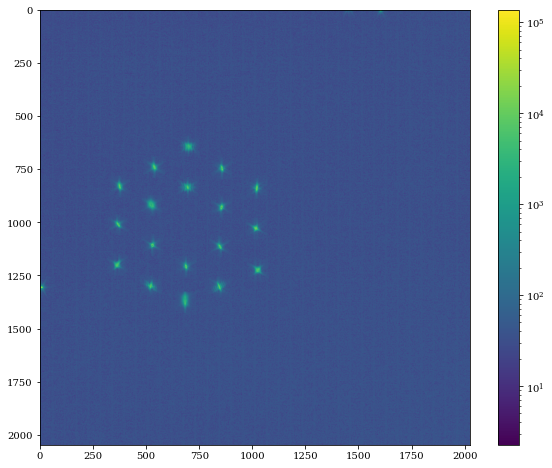

In [14]:
sci = fits.getdata(path_to_id_image_cal)
print(np.shape(sci))

plt.figure(figsize=(10, 8))
plt.imshow(sci[0], norm=LogNorm())
plt.colorbar()
plt.show()

In [15]:
bk_sub_sci = sci[0] - np.median(np.asarray(sci[0])) # Remove background as much as possible

center_of_array = (690, 1000) #Eye ball the center of the array
radius_of_window = 500

cropped = bk_sub_sci[center_of_array[1]-radius_of_window: center_of_array[1]+radius_of_window,
                     center_of_array[0]-radius_of_window: center_of_array[0]+radius_of_window]

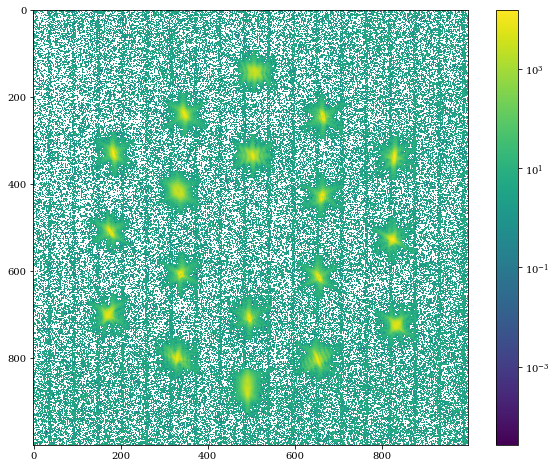

In [16]:
plt.figure(figsize=(10,8))
plt.imshow(cropped, norm=LogNorm())
plt.colorbar()
plt.show()

In [17]:
# Pad the image to a 2048x2048 image
pad = (2048 - (2*radius_of_window)) // 2
padded_sci = np.pad(cropped, pad, 'constant')

if np.shape(padded_sci) != (2048, 2048):
    print(f'The shape of the input data is not as expected ({np.shape(padded_sci)}, adjust the padding function accordingly')

In [18]:
# Make sure that the associated data is the same shape as the SCI image
err = hdu['ERR'].data
padded_err = np.pad(err[0], ((0,0), (12,12)), 'constant')
if np.shape(padded_err) != (2048, 2048):
    print('The shape of the input data is not as expected, adjust the padding function accordingly')

dq = hdu['DQ'].data
padded_dq = np.pad(dq, ((0,0), (12,12)), 'constant')
if np.shape(padded_dq) != (2048, 2048):
    print('The shape of the input data is not as expected, adjust the padding function accordingly')

In [19]:
# Put these back into the file that we will be using and write it out
hdu['SCI'].data = padded_sci
hdu['ERR'].data = padded_err
hdu['DQ'].data = padded_dq

path, filename = os.path.split(path_to_id_image_cal)
new_filename = f'expanded_{filename}'
outfile = os.path.join('/Users/kbrooks/Desktop', new_filename)
hdu.writeto(outfile, overwrite=True)

# Run this image through the backend of MAGIC to create a pseudo-FGS image 

In [20]:
# Be sure to change the root and out_dir as it relates to your observation
# Input image and paths
input_image = outfile # This is the same image that you just wrote out
root = 'from_ote07_obs1_id' # Change this root to something that makes sense for this observation
out_dir = '/Users/kbrooks/Desktop/MAGIC/test/' # Change this path

# Smoothing information
smoothing = 'high' #"high" for large smoothing (e.g. Global Alignment), "default" for medium smoothing 

In [21]:
fits.info(input_image)

Filename: /Users/kbrooks/Desktop/expanded_jw00646183001_gs-id_1_image_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     162   ()      
  1  SCI           1 ImageHDU        53   (2048, 2048)   float32   
  2  ERR           1 ImageHDU         9   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  PLANNED REFERENCE STARS    1 BinTableHDU     30   6R x 10C   [J, 12A, D, D, D, D, D, D, D, D]   
  5  FLIGHT REFERENCE STARS    1 BinTableHDU     19   200R x 4C   [2A, D, D, D]   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [16586589B]   


In [22]:
# Create a peusdo-FGS image from the ID image
convert_id_to_fgs_raw(input_image, root, out_dir, guider, smoothing)

2022-01-13 13:43:51,739 - INFO - Started logging to file /Users/kbrooks/Desktop/MAGIC/test/out/from_ote07_obs1_id/2022_01_13_Thu_134351_main_from_ote07_obs1_id.log
2022-01-13 13:43:51,740 - INFO - Package directory: /Users/kbrooks/git_repos/jwst-magic-fork/
2022-01-13 13:43:51,740 - INFO - Processing request for from_ote07_obs1_id.
2022-01-13 13:43:51,741 - INFO - All data will be saved in: /Users/kbrooks/Desktop/MAGIC/test/out/from_ote07_obs1_id
2022-01-13 13:43:51,742 - INFO - Input image: /Users/kbrooks/Desktop/expanded_jw00646183001_gs-id_1_image_cal.fits
2022-01-13 13:43:51,875 - INFO - Image Conversion: Beginning image conversion to guider 1 FGS image
2022-01-13 13:43:51,876 - INFO - Image Conversion: Input image is expected to be in units of ADU/sec (countrate)
2022-01-13 13:43:59,270 - INFO - Image Conversion: Bad pixels removed from image using DQ array from image.
2022-01-13 13:43:59,271 - INFO - Image Conversion: Image in correct units of ADU/s.
2022-01-13 13:43:59,288 - INF

In [23]:
# Make a table of the all found PSFs
all_psfs_filename = os.path.join(out_dir, 'out', root, f'unshifted_all_found_psfs_{root}_G{guider}.txt')
all_psfs_table = read_all_found_psfs(all_psfs_filename)

all_psfs_table

,label,segment,y,x,countrate
8,N,A1-1,1018.0,1189.0,92530.4463
4,L,A2-2,859.0,1095.0,98461.8320
5,H,A3-3,867.0,910.0,88735.8672
9,E,A4-4,1026.0,816.0,99237.4111
12,G,A5-5,1184.0,917.0,80349.1865
13,K,A6-6,1189.0,1106.0,34408.5588
7,R,B1-7,1014.0,1381.0,37693.9841
1,O,B2-9,693.0,1185.0,109606.0586
0,F,B3-11,688.0,800.0,58980.4243
10,A,B4-13,1031.0,654.0,44823.6899


### Do a quick visual check to make sure that the identified segments are correct 

In [19]:
pseudo_fgs = fits.getdata(os.path.join(out_dir, 'out', root, 'FGS_imgs', 
                                       f'unshifted_{root}_G{guider}.fits'))

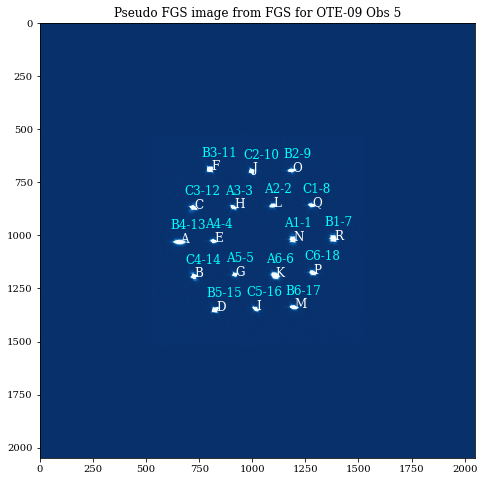

In [21]:
xs = all_psfs_table['x'].values
ys = all_psfs_table['y'].values
labels = all_psfs_table['label'].values
segments = all_psfs_table['segment'].values

plt.figure(figsize=(10, 8))
plt.imshow(pseudo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='upper')
plt.title(f"Pseudo FGS image from FGS")
for segment, label, y, x in zip(segments, labels, ys, xs):
    plt.annotate(label, (x, y), (x+5, y+5), color='white', fontsize=12)
    plt.annotate(segment, (x, y), (x-40, y-60), color='cyan', fontsize=12)
plt.show()

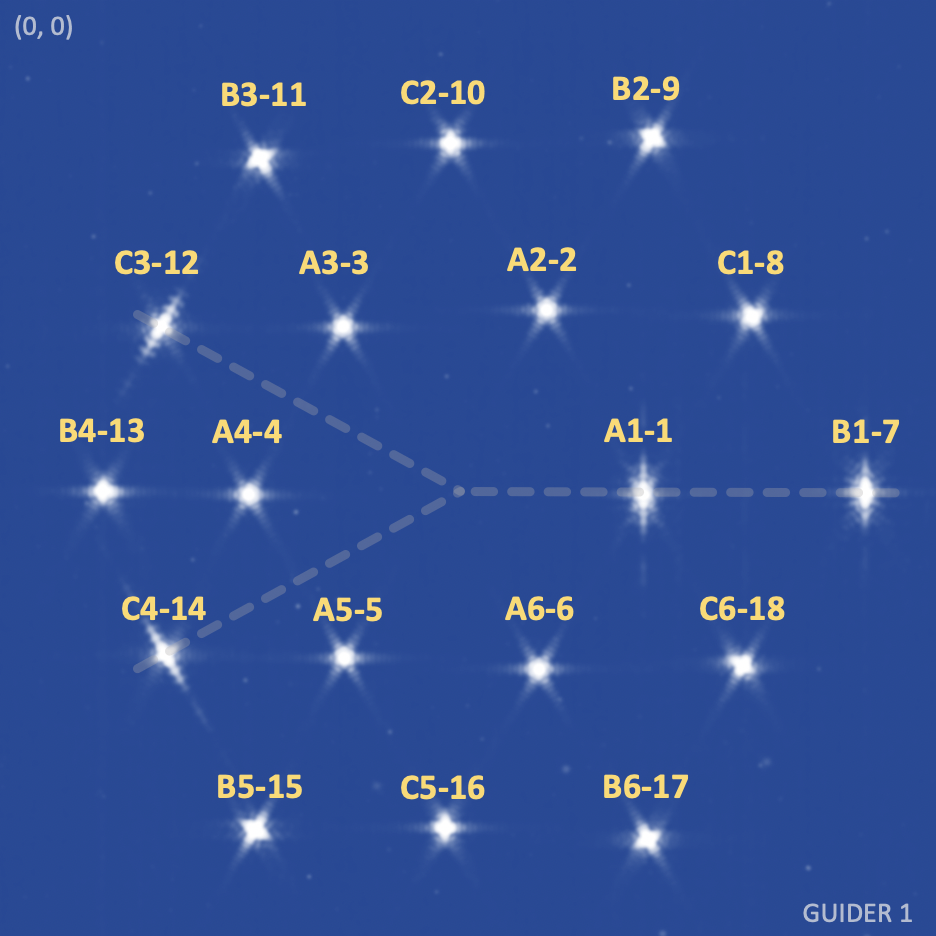

In [34]:
Image(filename=orientation_filename, height=400, width=400) 

Confirm that the segments found are consistent with the diagrams above (depending on which guider is being used) and matches what is given in the all_psfs_table for the pseudo-FGS image from the ID strips. If you need to update the segment names in the table, you can do so by creating a list of the actual segment IDs in order as they appear in the table (for example called `actual_segments` and run a cell with the following lines of code: 
```
actual_segments = [,] # Fill in this list
all_psfs_table['segment'] = actual_segments
```

In [24]:
all_psfs_table

,label,segment,y,x,countrate
8,N,A1-1,1018.0,1189.0,92530.4463
4,L,A2-2,859.0,1095.0,98461.8320
5,H,A3-3,867.0,910.0,88735.8672
9,E,A4-4,1026.0,816.0,99237.4111
12,G,A5-5,1184.0,917.0,80349.1865
13,K,A6-6,1189.0,1106.0,34408.5588
7,R,B1-7,1014.0,1381.0,37693.9841
1,O,B2-9,693.0,1185.0,109606.0586
0,F,B3-11,688.0,800.0,58980.4243
10,A,B4-13,1031.0,654.0,44823.6899


# About this notebook

Author: K. Brooks

Last updated: 13 Jan, 2022